Best Fit Curve: y=
            3             2
-9.869e-07 x + 9.806e-05 x - 0.00405 x + 0.1155


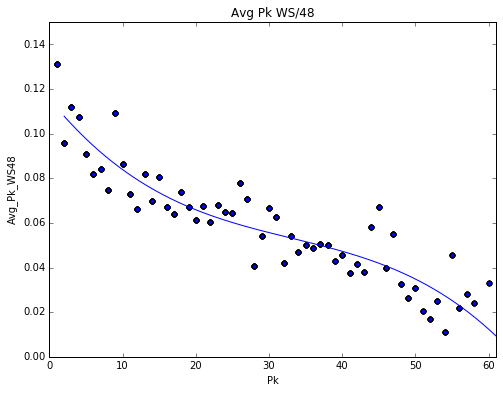

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit
%matplotlib inline

# Read data and limit to 2015 or earlier
df = pd.DataFrame.from_csv('data.csv')
df = df.loc[df['Year'] <= 2015]

# Take average pick value
df['Avg_Pk_WS48'] = df.groupby('Pk')['WS/48'].transform(lambda x: x.mean())

# Curve fitting seems to do the trick, although I'd like to keep pick #1 without the curve fit
X = df['Pk']
Y = df['Avg_Pk_WS48']
z = np.polyfit(X, Y, 3)   
f = np.poly1d(z)
x_new = np.linspace(2, 61, 500)
y_new = f(x_new)
print "Best Fit Curve: y="
print f
df.plot(y='Avg_Pk_WS48', x='Pk', kind='scatter', \
          title='Avg Pk WS/48', xlim=(0, 61), ylim=(0, 0.15), figsize=(8, 6))
plt.plot(x_new, y_new)

In [2]:
df = df.sort_values('Pk')
x = df['Pk']

# Apply curve fit
df['Curve_Fit_Pk_WS48'] = f[3]*(x**3) + f[2]*(x**2) + f[1]*x + f[0]
# Replace #1 suggested by curve fir with simple average #1 pick
df.loc[df.Pk == 1, ['Curve_Fit_Pk_WS48']] = df['Avg_Pk_WS48']

In [3]:
df = df.sort_values('Pk')
df = df.set_index('Year')

# Create lists of variables and following
WS = df['WS/48'].groupby(df.index).agg(lambda x: list(list(x)))
cum_list = []
for i in range(1996, 2016):
    mini_list = []
    for j in range(len(WS[i])):
        mini_list.append(WS[i][j+1:j+6])
    cum_list.append(mini_list)
cum_list = [item for sublist in cum_list for item in sublist]
 
df = df.reset_index().sort_values(['Year', 'Pk'])

# Sequence for weighing pick value. The selection is worth 1, the next pick is worth 0.75, etc.
simple_transform = [[1, .5, float(1)/3, .25, .2] for i in range(len(df))]
print "Weight Sequence:", simple_transform[0]
    
# Apply sequence
df['Weighted_Following_5'] = [sum([y*simple_transform[xi][yi]/sum(simple_transform[0]) for yi,y in enumerate(x)])
                                 for xi,x in enumerate(cum_list)]
df.sort('Weighted_Following_5', ascending=False).head(10)[['Year', 'Pk', 'Player', 'Weighted_Following_5']]

Weight Sequence: [1, 0.5, 0.3333333333333333, 0.25, 0.2]


C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Year,Pk,Player,Weighted_Following_5
10,2007,1,Greg Oden,0.159489
40,2005,3,Deron Williams,0.153518
159,1998,8,Larry Hughes,0.151971
222,1996,12,Vitaly Potapenko,0.149504
59,2008,3,O.J. Mayo,0.144489
278,2011,14,Marcus Morris,0.143591
34,2009,2,Hasheem Thabeet,0.139861
16,2001,1,Kwame Brown,0.139102
122,2007,7,Corey Brewer,0.137226
29,2005,2,Marvin Williams,0.137190


In [4]:
# Sum the metric for each draft
df['Draft_Value'] = df.groupby('Year')['WS/48'].transform(lambda x: x.sum())
df['Pick_Context'] = (df['WS/48']*df['Draft_Value']) - df['Avg_Pk_WS48']
df.sort('Pick_Context', ascending=False).head(20)[['Year', 'Pk', 'Player', 'Pick_Context']]

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Year,Pk,Player,Pick_Context
79,2005,4,Chris Paul,0.908100
298,2011,15,Kawhi Leonard,0.756054
41,2009,3,James Harden,0.747610
135,2009,7,Stephen Curry,0.739065
39,2007,2,Kevin Durant,0.672133
674,2008,35,DeAndre Jordan,0.668871
94,2008,5,Kevin Love,0.657200
14,2003,1,LeBron James,0.642871
584,2011,30,Jimmy Butler,0.636324
1039,1999,57,Manu Ginobili,0.621722


Best Fit Line: y=
 
-0.003087 x + 0.2289


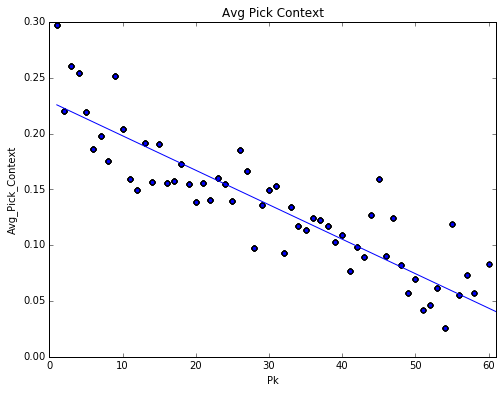

In [5]:
df['Avg_Pick_Context'] = df.groupby('Pk')['Pick_Context'].transform(lambda x: x.mean())
df.plot(y='Avg_Pick_Context', x='Pk', kind='scatter', \
          title='Avg Pick Context', xlim=(0, 61), ylim=(0, 0.3), figsize=(8, 6))
# Line fitting seems to do the trick
X = df['Pk']
Y = df['Avg_Pick_Context']
z = np.polyfit(X, Y, 1)   
f = np.poly1d(z)
x_new = np.linspace(1, 61, 500)
y_new = f(x_new)
print "Best Fit Line: y="
print f
plt.plot(x_new, y_new)

In [10]:
# Clearly this needs to be accounted for
df = df.sort_values('Pk')
x = df['Pk']
df['Line_Fit_Pk_Difference'] = f[1]*x + f[0]

# Calculate the difference once more
df['Adj_Pick_Context'] = df['Pick_Context'] - df['Line_Fit_Pk_Difference']

In [7]:
# Subtract the metric by the weighted following
df['Opportunity_Cost'] = (df['WS/48'] - df['Weighted_Following_5'])
df.sort('Opportunity_Cost', ascending=False).head(15)[['Year', 'Pk', 'Player', 'Opportunity_Cost']]

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,Year,Pk,Player,Opportunity_Cost
1039,1999,57,Manu Ginobili,0.196000
792,2014,41,Nikola Jokic,0.191474
647,2010,33,Hassan Whiteside,0.188445
534,2013,27,Rudy Gobert,0.177810
79,2005,4,Chris Paul,0.170482
847,2010,44,Jerome Jordan,0.168000
1081,2011,60,Isaiah Thomas,0.165000
751,2013,39,Jeff Withey,0.159774
13,2002,1,Yao Ming,0.157628
1046,2005,57,Marcin Gortat,0.154277


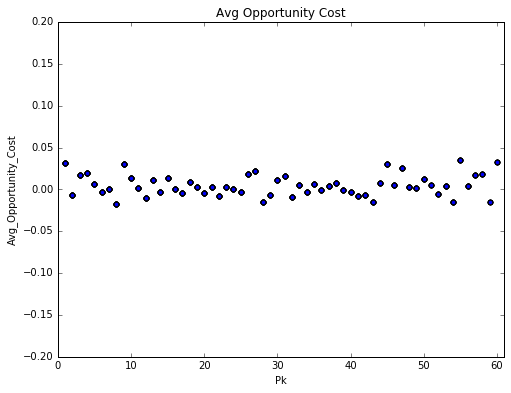

In [8]:
df['Avg_Opportunity_Cost'] = df.groupby('Pk')['Opportunity_Cost'].transform(lambda x: x.mean())
df.plot(y='Avg_Opportunity_Cost', x='Pk', kind='scatter', \
          title='Avg Opportunity Cost', xlim=(0, 61), ylim=(-0.2, 0.2), figsize=(8, 6))

In [12]:
df_TM = df.groupby('Tm').mean()
df_TM = df_TM.sort('Adj_Pick_Context', ascending=False).rank(ascending=False)[['Adj_Pick_Context', 'Opportunity_Cost']]
df_TM

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Adj_Pick_Context,Opportunity_Cost
Tm,,
SAS,1.0,2.0
NOP,2.0,1.0
IND,3.0,12.0
OKC,4.0,3.0
HOU,5.0,5.0
GSW,6.0,7.0
NYK,7.0,13.0
MIL,8.0,17.0
UTA,9.0,6.0
